In [ ]:
#TODO" on the dataset

# Pull cohort from 2009Q1, create EffectiveDate, group by month, compute SAT and define other Time-invariant covariates -- metafeatures

# merge on its performance next month, compute extected balance and compare to reported balance, add Market rate adn other time-related covariates

# target Status

# repeat 12 times till the end of the first year, train, predict Status as multi class classifier and balance as regression

# compare to the actual survival, if not impressive repeat for 36 months... or 5 years

# Finally, how to deal with time-invariate metadata -- ConditionalRNN

# Isolating: https://stackoverflow.com/questions/57324671/combine-time-series-with-time-invariant-data-in-rnn-lstm-using-keras-functional

# Theory https://datascience.stackexchange.com/questions/17099/adding-features-to-time-series-model-lstm/17139#17139

# Isolating: https://github.com/philipperemy/cond_rnn

# Combining: https://stats.stackexchange.com/questions/191176/time-series-with-rnn-how-to-deal-with-attributes-that-span-entire-sequences

# Attention based: https://diginole.lib.fsu.edu/islandora/object/fsu:826790/datastream/PDF/view

 

# Final plots:

# Finetuning: https://ml-lectures.org/docs/supervised_learning_w_NNs/NN-opt-reg.html

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

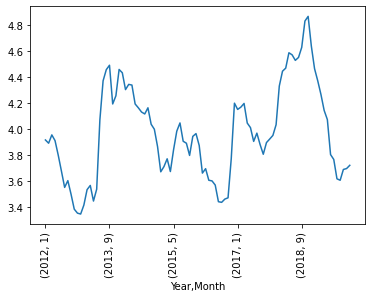

In [9]:
rate = pd.read_csv('../help/MORTGAGE30US.csv')
rate['DATE'] = rate['DATE'].astype('datetime64[ns]')
rate['Year'] = rate['DATE'].dt.year
rate['Month'] = rate['DATE'].dt.month
rate.loc[(rate['Year']>2011) & (rate['Year']<2020)].groupby(['Year', 'Month'])['MORTGAGE30US'].mean().plot(kind='line', rot=90)
plt.show()

In [175]:
orig_helper = pd.read_csv('../help/orig_read_helper.csv')
orig_col_names = orig_helper['ATTRIBUTE NAME'].to_list()

In [177]:
df = pd.read_csv('../data/historical_data_2015Q1.txt', sep='|',
                 header=None, names=orig_col_names, low_memory=False)

In [178]:
len(df)

365234

In [180]:
df = df.loc[df['Original Loan Term']==360].copy()

In [181]:
df['MatDate'] = pd.to_datetime(df['Maturity Date'], errors='raise', format='%Y%m')
df['OrgDate'] = df['MatDate'] - DateOffset(months=361)

In [182]:
df['OrgYear'] = df['OrgDate'].dt.year
df['OrgMnth'] = df['OrgDate'].dt.month

In [200]:
#cohort_2015q1_df = df.loc[(df['OrgYear']==2015) & (df['OrgMnth']==2)]

In [201]:
cohort_2015q1_df.groupby('OrgDate')['Loan Sequence Number'].count()

OrgDate
2015-01-01    63701
Name: Loan Sequence Number, dtype: int64

In [191]:
cohort_2015q1_df.shape

(63701, 36)

In [192]:
#cohort_2015q1_df.to_csv('../data/cohort_2015q1_df.csv', index=False)

In [193]:
perf_helper = pd.read_csv('../help/perf_read_helper.csv')
perf_col_names = perf_helper['ATTRIBUTE NAME'].to_list()

In [194]:
df = pd.read_csv('../data/historical_data_time_2015Q1.txt', sep='|', 
                 header=None,names=perf_col_names, low_memory=False)

In [318]:
print(list(cohort_2015q1_df.columns))

['Credit Score', 'First Payment Date', 'First Time Homebuyer Flag', 'Maturity Date', 'Metropolitan Statistical Area (MSA) Or Metropolitan Division', 'Mortgage Insurance Percentage (MI %)', 'Number of Units', 'Occupancy Status', 'Original Combined Loan-to-Value (CLTV)', 'Original Debt-to-Income (DTI) Ratio', 'Original UPB', 'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Channel', 'Prepayment Penalty Mortgage (PPM) Flag', 'Amortization Type (Formerly Product Type)', 'Property State', 'Property Type', 'Postal Code', 'Loan Sequence Number', 'Loan Purpose', 'Original Loan Term', 'Number of Borrowers', 'Seller Name', 'Servicer Name', 'Super Conforming Flag', 'Pre-HARP Loan Sequence Number', 'Program Indicator', 'HARP Indicator', 'Property Valuation Method', 'Interest Only (I/O) Indicator', 'Mortgage Insurance Cancellation Indicator', 'MatDate', 'OrgDate', 'OrgYear', 'OrgMnth']


In [197]:
df['RepDate'] = pd.to_datetime(df['Monthly Reporting Period'], errors='raise', format='%Y%m')
df['RepYear'] = df['RepDate'].dt.year
df['RepMnth'] = df['RepDate'].dt.month

In [350]:
merged_df = pd.merge(cohort_2015q1_df[['Credit Score', 'First Payment Date', 'First Time Homebuyer Flag', 
                                       'Mortgage Insurance Percentage (MI %)', 'Number of Units', 
                                       'Occupancy Status', 'Original Combined Loan-to-Value (CLTV)', 
                                       'Original Debt-to-Income (DTI) Ratio', 'Original UPB', 
                                       'Original Loan-to-Value (LTV)', 'Original Interest Rate', 
                                       'Channel', 'Amortization Type (Formerly Product Type)', 
                                       'Property State', 'Property Type', 
                                       'Loan Sequence Number', 'Loan Purpose', 
                                       'Original Loan Term', 'Number of Borrowers',
                                       'Mortgage Insurance Cancellation Indicator', 
                                       'MatDate', 'OrgDate', 'OrgYear', 'OrgMnth']], 
                     df[['Loan Sequence Number', 
                         'RepDate', 'Loan Age', 'RepYear', 'RepMnth',
                         'Zero Balance Effective Date',
                         'Zero Balance Code']],
                     how='left',
                     left_on=['Loan Sequence Number'],
                     right_on = ['Loan Sequence Number']                    
                    )

In [320]:
#merged_df.drop(columns=['Loan Sequence Number'], inplace=True)

In [276]:
#merged_df.to_csv('../data/perf_2015q1_df.csv', index=False)

In [351]:
prepaid_12months = merged_df.loc[(merged_df['RepYear']==2015) & (merged_df['Zero Balance Code']==1)].copy()

In [352]:
merged_df['Zero Balance Code'].fillna(0, inplace=True)

In [353]:
survived_12months = merged_df.loc[
    (merged_df['RepYear']==2015) & (merged_df['Zero Balance Code']==0)].sample(len(prepaid_12months)).copy()

In [323]:
# prepaid_12months.reset_index(inplace=True, drop=True)
# survived_12months.reset_index(inplace=True, drop=True)

In [354]:
estimation_2015q1 = pd.concat([prepaid_12months, survived_12months], ignore_index=True, axis=0)

In [355]:
estimation_2015q1 = estimation_2015q1.sample(frac=1).reset_index(drop=True)

In [360]:
#estimation_2015q1['EffDate'] = pd.to_datetime(df['Zero Balance Effective Date'], errors='raise', format='%Y%m')

In [362]:
estimation_2015q1.groupby('Zero Balance Effective Date')['Loan Sequence Number'].count()

Zero Balance Effective Date
201502.0     17
201503.0     81
201504.0    115
201505.0    183
201506.0    271
201507.0    287
201508.0    314
201509.0    319
201510.0    365
201511.0    401
201512.0    384
Name: Loan Sequence Number, dtype: int64

In [367]:
rate['RateDate'] = pd.to_datetime(rate['DATE'], errors='raise')

In [391]:
selected_rates = rate.loc[(rate['RateDate']>'2015-02-01') & (rate['RateDate']<'2016-01-01')][
    ['RateDate', 'MORTGAGE30US']]

In [449]:
columns = list(selected_rates['RateDate'].astype(str).values)
data = list(selected_rates['MORTGAGE30US'].values)

In [504]:
import numpy as np
arr = np.ones((len(estimation_2015q1), len(incv_df.columns)))
arr_data = arr * np.asarray(data)
incv_df = pd.DataFrame(arr_data)
incv_df.columns=columns

In [514]:
estimation_2015q1[incv_df.columns] = -incv_df.values

In [515]:
for col in estimation_2015q1[incv_df.columns]:
    estimation_2015q1[col] = estimation_2015q1[col]+estimation_2015q1['Original Interest Rate']

In [517]:
estimation_2015q1.columns

Index(['Credit Score', 'First Payment Date', 'First Time Homebuyer Flag',
       'Mortgage Insurance Percentage (MI %)', 'Number of Units',
       'Occupancy Status', 'Original Combined Loan-to-Value (CLTV)',
       'Original Debt-to-Income (DTI) Ratio', 'Original UPB',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Channel',
       'Amortization Type (Formerly Product Type)', 'Property State',
       'Property Type', 'Loan Sequence Number', 'Loan Purpose',
       'Original Loan Term', 'Number of Borrowers',
       'Mortgage Insurance Cancellation Indicator', 'MatDate', 'OrgDate',
       'OrgYear', 'OrgMnth', 'RepDate', 'Loan Age', 'RepYear', 'RepMnth',
       'Zero Balance Effective Date', 'Zero Balance Code', 'EffDate',
       '2015-02-05', '2015-02-12', '2015-02-19', '2015-02-26', '2015-03-05',
       '2015-03-12', '2015-03-19', '2015-03-26', '2015-04-02', '2015-04-09',
       '2015-04-16', '2015-04-23', '2015-04-30', '2015-05-07', '2015-05-14',
       '2015-05-21

In [518]:
estimation_2015q1.to_csv('../data/estimation_2015q1.csv', index=False)

### Predictors

In [528]:
estimation_2015q1['Mortgage Insurance Cancellation Indicator'].unique()

array(['7', 'Y', 'N'], dtype=object)

In [530]:
data = estimation_2015q1[['Credit Score', # Continious
                   'Original Debt-to-Income (DTI) Ratio',
                   'Original Combined Loan-to-Value (CLTV)',
                   'Original Loan-to-Value (LTV)', 
                   'Original Interest Rate',
                   'Original UPB',
                   'First Time Homebuyer Flag', # Descrete
                   'Mortgage Insurance Percentage (MI %)', 
                   'Number of Units', 'Occupancy Status', 
                   'Channel','Property State',
                   'Property Type', 
                   'Loan Purpose', 
                   'Number of Borrowers', 
                   'Mortgage Insurance Cancellation Indicator',
                   '2015-02-05', '2015-02-12', '2015-02-19', '2015-02-26', '2015-03-05', # Time variant
       '2015-03-12', '2015-03-19', '2015-03-26', '2015-04-02', '2015-04-09',
       '2015-04-16', '2015-04-23', '2015-04-30', '2015-05-07', '2015-05-14',
       '2015-05-21', '2015-05-28', '2015-06-04', '2015-06-11', '2015-06-18',
       '2015-06-25', '2015-07-02', '2015-07-09', '2015-07-16', '2015-07-23',
       '2015-07-30', '2015-08-06', '2015-08-13', '2015-08-20', '2015-08-27',
       '2015-09-03', '2015-09-10', '2015-09-17', '2015-09-24', '2015-10-01',
       '2015-10-08', '2015-10-15', '2015-10-22', '2015-10-29', '2015-11-05',
       '2015-11-12', '2015-11-19', '2015-11-25', '2015-12-03', '2015-12-10',
       '2015-12-17', '2015-12-24', '2015-12-31']]

In [531]:
data.isna().sum()

Credit Score                              0
Original Debt-to-Income (DTI) Ratio       0
Original Combined Loan-to-Value (CLTV)    0
Original Loan-to-Value (LTV)              0
Original Interest Rate                    0
                                         ..
2015-12-03                                0
2015-12-10                                0
2015-12-17                                0
2015-12-24                                0
2015-12-31                                0
Length: 64, dtype: int64

In [532]:
data.columns

Index(['Credit Score', 'Original Debt-to-Income (DTI) Ratio',
       'Original Combined Loan-to-Value (CLTV)',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate',
       'Original UPB', 'First Time Homebuyer Flag',
       'Mortgage Insurance Percentage (MI %)', 'Number of Units',
       'Occupancy Status', 'Channel', 'Property State', 'Property Type',
       'Loan Purpose', 'Number of Borrowers',
       'Mortgage Insurance Cancellation Indicator', '2015-02-05', '2015-02-12',
       '2015-02-19', '2015-02-26', '2015-03-05', '2015-03-12', '2015-03-19',
       '2015-03-26', '2015-04-02', '2015-04-09', '2015-04-16', '2015-04-23',
       '2015-04-30', '2015-05-07', '2015-05-14', '2015-05-21', '2015-05-28',
       '2015-06-04', '2015-06-11', '2015-06-18', '2015-06-25', '2015-07-02',
       '2015-07-09', '2015-07-16', '2015-07-23', '2015-07-30', '2015-08-06',
       '2015-08-13', '2015-08-20', '2015-08-27', '2015-09-03', '2015-09-10',
       '2015-09-17', '2015-09-24', '2015-10-0

In [535]:
data = pd.get_dummies(data, columns=['First Time Homebuyer Flag',
       'Mortgage Insurance Percentage (MI %)', 'Number of Units',
       'Occupancy Status', 'Channel', 'Property State', 'Property Type',
       'Loan Purpose', 'Number of Borrowers',
       'Mortgage Insurance Cancellation Indicator'], drop_first=False)

In [536]:
data.columns

Index(['Credit Score', 'Original Debt-to-Income (DTI) Ratio',
       'Original Combined Loan-to-Value (CLTV)',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate',
       'Original UPB', '2015-02-05', '2015-02-12', '2015-02-19', '2015-02-26',
       ...
       'Property Type_PU', 'Property Type_SF', 'Loan Purpose_C',
       'Loan Purpose_N', 'Loan Purpose_P', 'Number of Borrowers_1',
       'Number of Borrowers_2', 'Mortgage Insurance Cancellation Indicator_7',
       'Mortgage Insurance Cancellation Indicator_N',
       'Mortgage Insurance Cancellation Indicator_Y'],
      dtype='object', length=139)

In [ ]:
# First do train test valid split and then transform...
X_train

# Pop y 

In [537]:
# demonstrate data standardization with sklearn
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on data
scaler.fit(data)
# apply transform
standardized = scaler.transform(data)

In [538]:
standardized

array([[ 0.9495238 , -0.30620426,  0.24354526, ...,  0.57411579,
        -0.52563122, -0.18011271],
       [-0.10280603, -0.26002773,  1.1189776 , ..., -1.74180892,
        -0.52563122,  5.55207902],
       [-0.01690156, -0.26002773,  1.1189776 , ..., -1.74180892,
         1.90247452, -0.18011271],
       ...,
       [-0.08132991, -0.28311599,  1.1189776 , ..., -1.74180892,
         1.90247452, -0.18011271],
       [ 0.58442978, -0.28696404, -1.33223296, ...,  0.57411579,
        -0.52563122, -0.18011271],
       [ 0.69181037, -0.37162102, -0.28171415, ...,  0.57411579,
        -0.52563122, -0.18011271]])